Bureau of Economic Analysis API with Python
=====



Example of using the BEA's API to retrieve data. 

The BEA API documentation is available [here](https://www.bea.gov/API/bea_web_service_api_user_guide.htm) and you can [get key](https://apps.bea.gov/api/signup/).

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import requests
import pandas as pd
import httpx
from dotenv import load_dotenv

load_dotenv()
api_key = os.environ.get("BUREAU_API_KEY")

# base urls
base = f'https://apps.bea.gov/api/data/?&UserID={api_key}'
formatting = "&ResultFormat=json"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### List of datasets available 

In [36]:
method = "&method=GETDATASETLIST"
r1 = httpx.get(f"{base}{method}{formatting}").json()

In [40]:
datasets = [x['DatasetName'] for x in r1["BEAAPI"]["Results"]['Dataset']]
print(f"there are {len(datasets)} datasets available")
for d in datasets:
       print('• ', d)

there are 13 datasets available
•  NIPA
•  NIUnderlyingDetail
•  MNE
•  FixedAssets
•  ITA
•  IIP
•  InputOutput
•  IntlServTrade
•  IntlServSTA
•  GDPbyIndustry
•  Regional
•  UnderlyingGDPbyIndustry
•  APIDatasetMetaData


### List of parameters availablea for dataset

In [73]:
# Get parameters for a dataset
# Loop through all datasets and get their parameters
all_parameters = []
with open('bea_parameters.txt', 'w') as f:
    for dataset_name in [d for d in datasets if d != 'APIDatasetMetaData']:
        f.write(f"\n=== Parameters for {dataset_name} ===\n")
        print(f"\n=== Parameters for {dataset_name} ===")
        
        dataset = f"&datasetname={dataset_name}"
        method_get_params = "&method=GETPARAMETERLIST"
        
        try:
            r2 = httpx.get(f"{base}{method}{dataset}{formatting}").json()
            parameters = [(x['ParameterName'], x["ParameterDataType"], 
                          x['ParameterDescription'], x['ParameterIsRequiredFlag'], x['MultipleAcceptedFlag']) 
                         for x in r2["BEAAPI"]["Results"]['Parameter']]
            all_parameters.extend(parameters)

            # Sort parameters by required flag (1 first, then 0)
            sorted_params = sorted(parameters, key=lambda x: x[3], reverse=True)
            for p in sorted_params:
                if p[3] == '1':  # Required parameter
                    line = f"🔒 {p[0]:<15} {p[1]:<10} {p[2]:<50} {p[3]} {p[4]}"
                    f.write(line + "\n")
                    print(line)
                else:  # Optional parameter
                    line = f"• {p[0]:<15} {p[1]:<10} {p[2]:<50} {p[3]} {p[4]}"
                    f.write(line + "\n")
                    print(line)
        except Exception as e:
            error_msg = f"Error getting parameters for {dataset_name}: {str(e)}"
            f.write(error_msg + "\n")
            print(error_msg)


=== Parameters for NIPA ===
🔒 Frequency       string     A - Annual, Q-Quarterly, M-Monthly                 1 1
🔒 Year            integer    List of year(s) of data to retrieve (X for All)    1 1
• ShowMillions    string     A flag indicating that million-dollar data should be returned. 0 0
• TableID         integer    The standard NIPA table identifier                 0 0
• TableName       string     The new NIPA table identifier                      0 0

=== Parameters for NIUnderlyingDetail ===
🔒 Frequency       string     A - Annual, Q-Quarterly, M-Monthly                 1 1
🔒 Year            integer    List of year(s) of data to retrieve (X for All)    1 1
• TableID         integer    The standard NI underlying detail table identifier 0 0
• TableName       string     The new NIPA table identifier                      0 0

=== Parameters for MNE ===
🔒 DirectionOfInvestment string     Four Possible Values:  (inward,outward,parent,state) 1 0
🔒 Classification  string     Classificat

### Getting data from BEA API

In [ ]:
def get_nipa_data(year, frequency, table_id=25):
    dataset = '&datasetname=NIPA'
    method_get_data = "&method=GetData"
    url_nipa = f"{base}{method_get_data}{dataset}&TableName={table_id}&Year={year}&Frequency={frequency}{formatting}"
    print(url_nipa)
    r = httpx.get(url_nipa).json()
    return r


r3 = get_nipa_data('2023', 'Q', "T10101" )

https://apps.bea.gov/api/data/?&UserID=1D11E9D5-5C26-4650-8C1E-8879C38CFEBD&method=GetData&datasetname=NIPA&TableName=T10101&Year=2023&Frequency=Q&ResultFormat=json


{'Statistic': 'NIPA Table',
 'UTCProductionTime': '2025-04-09T15:09:10.657',
 'Dimensions': [{'Ordinal': '1',
   'Name': 'TableName',
   'DataType': 'string',
   'IsValue': '0'},
  {'Ordinal': '2', 'Name': 'SeriesCode', 'DataType': 'string', 'IsValue': '0'},
  {'Ordinal': '3',
   'Name': 'LineNumber',
   'DataType': 'numeric',
   'IsValue': '0'},
  {'Ordinal': '4',
   'Name': 'LineDescription',
   'DataType': 'string',
   'IsValue': '0'},
  {'Ordinal': '5', 'Name': 'TimePeriod', 'DataType': 'string', 'IsValue': '0'},
  {'Ordinal': '6', 'Name': 'CL_UNIT', 'DataType': 'string', 'IsValue': '0'},
  {'Ordinal': '7', 'Name': 'UNIT_MULT', 'DataType': 'numeric', 'IsValue': '0'},
  {'Ordinal': '8',
   'Name': 'METRIC_NAME',
   'DataType': 'string',
   'IsValue': '0'},
  {'Ordinal': '9',
   'Name': 'DataValue',
   'DataType': 'numeric',
   'IsValue': '1'}],
 'Data': [{'TableName': 'T10101',
   'SeriesCode': 'A191RL',
   'LineNumber': '1',
   'LineDescription': 'Gross domestic product',
   'TimeP

In [77]:
pd.DataFrame(r3['BEAAPI']['Results']['Data']).sort_values(['TimePeriod', 'LineDescription', 'CL_UNIT'], ascending=[False, False, False])

TableName SeriesCode LineNumber   LineDescription TimePeriod  \
39    T10101     A009RL         10        Structures     2023Q4   
95    T10101     A829RL         26   State and local     2023Q4   
23    T10101     DSERRL          6          Services     2023Q4   
63    T10101     A646RL         18          Services     2023Q4   
75    T10101     A656RL         21          Services     2023Q4   
..       ...        ...        ...               ...        ...   
28    T10101     A007RL          8  Fixed investment     2023Q1   
80    T10101     A823RL         23           Federal     2023Q1   
52    T10101     A020RL         16           Exports     2023Q1   
40    T10101     Y033RL         11         Equipment     2023Q1   
12    T10101     DDURRL          4     Durable goods     2023Q1   

              METRIC_NAME                      CL_UNIT UNIT_MULT DataValue  \
39  Fisher Quantity Index  Percent change, annual rate         0       6.5   
95  Fisher Quantity Index  Percent change, annual rate         0       6.1   
23  Fisher Quantity Index  Percent change, annual rate         0       3.5   
63  Fisher Quantity Index  Percent change, annual rate         0       8.0   
75  Fisher Quantity Index  Percent change, annual rate         0      14.8   
..                    ...                          ...       ...       ...   
28  Fisher Quantity Index  Percent change, annual rate         0       3.1   
80  Fisher Quantity Index  Percent change, annual rate         0       4.6   
52  Fisher Quantity Index  Percent change, annual rate         0       2.0   
40  Fisher Quantity Index  Percent change, annual rate         0       0.9   
12  Fisher Quantity Index  Percent change, annual rate         0      17.1   

   NoteRef  
39  T10101  
95  T10101  
23  T10101  
63  T10101  
75  T10101  
..     ...  
28  T10101  
80  T10101  
52  T10101  
40  T10101  
12  T10101  

[100 rows x 10 columns]

### Use parameters obtained above to request data from API

In [5]:
m = '&method=GetData'
ind = '&TableId=25'
freq = '&Frequency=A'
year = '&Year=ALL'
fmt = '&ResultFormat=json'
indus = '&Industry=23'  # Construction Industry

# Combined url for request
url = '{}{}{}{}{}{}{}{}'.format(base, m, dataset, year, indus, ind, freq, fmt)

In [6]:
r = requests.get(url).json()

In [7]:
df = pd.DataFrame(r['BEAAPI']['Results'][0]['Data'])
df = df.replace('Construction', 'Gross Output')
df = df.set_index([pd.to_datetime(df['Year']), 'IndustrYDescription'])['DataValue'].unstack(1)
df = df.apply(pd.to_numeric)
df.tail()

IndustrYDescription  Compensation of employees  Energy inputs  Gross Output  \
Year                                                                          
2017-01-01                               520.4           35.4        1570.3   
2018-01-01                               558.3           42.3        1648.0   
2019-01-01                               598.5           37.9        1722.9   
2020-01-01                               598.3           32.5        1795.9   
2021-01-01                               635.6           48.6        1964.5   

IndustrYDescription  Gross operating surplus  Intermediate inputs  \
Year                                                                
2017-01-01                             270.1                769.6   
2018-01-01                             278.3                800.7   
2019-01-01                             294.0                818.9   
2020-01-01                             349.2                901.6   
2021-01-01                             331.4               1019.1   

IndustrYDescription  Materials inputs  Purchased-services inputs  \
Year                                                               
2017-01-01                      571.0                      163.3   
2018-01-01                      593.3                      165.1   
2019-01-01                      604.4                      176.6   
2020-01-01                      637.7                      231.4   
2021-01-01                      733.4                      237.1   

IndustrYDescription  Taxes on production and imports less subsidies  \
Year                                                                  
2017-01-01                                                     10.1   
2018-01-01                                                     10.7   
2019-01-01                                                     11.5   
2020-01-01                                                    -53.1   
2021-01-01                                                    -21.7   

IndustrYDescription  Value added  
Year                              
2017-01-01                 800.6  
2018-01-01                 847.3  
2019-01-01                 904.0  
2020-01-01                 894.4  
2021-01-01                 945.3

## Plot Employee share of gross profit

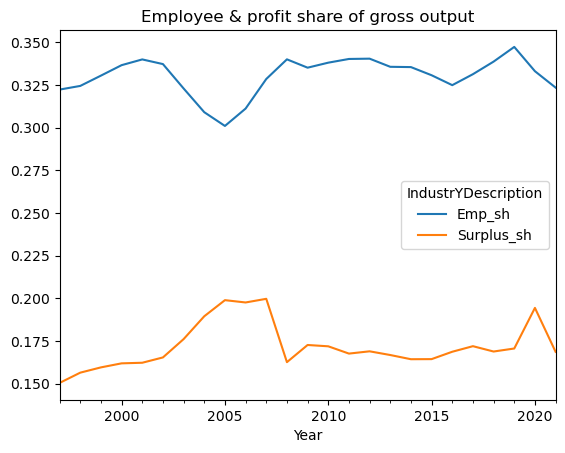

In [8]:
df['Emp_sh'] = df['Compensation of employees'] / df['Gross Output']
df['Surplus_sh'] = df['Gross operating surplus'] / df['Gross Output']

%matplotlib inline
df[['Emp_sh', 'Surplus_sh']].plot(title='Employee & profit share of gross output');

### GDP Report Data - Real PCE by Major Type of Product

REQUIRES PYTHON 3.6+

In [9]:
import requests
import pandas as pd
import config   ## File with API key

In [10]:
# Components of request
base = f'https://apps.bea.gov/api/data/?&UserID={config.bea_key}'
dset = '&method=GetData&datasetname=NIPA'
tbl = 'T20306' # Real PCE by Major Type of Product: NIPA Table 2.3.6.
freq = '&Frequency=Q'
yr = ','.join(map(str, range(2000, 2021)))
fmt = '&ResultFormat=json'
url = f'{base}{dset}&TableName={tbl}{freq}&Year={yr}{fmt}'

In [11]:
# Request data
r = requests.get(url).json()['BEAAPI']['Results']

In [12]:
d = {}

for series in ['DPCERX', 'DDURRX', 'DNDGRX', 'DSERRX']:
    data = [int(i['DataValue'].replace(',', ''))
            for i in r['Data'] if i['SeriesCode'] == series]
    index = [pd.to_datetime(i['TimePeriod'])
             for i in r['Data'] if i['SeriesCode'] == series]
    d[series] = pd.Series(data=data, index=index)

In [13]:
df = pd.DataFrame(d)
dft = df.diff()
dft = dft.div(dft['DPCERX'], axis=0)
df = dft.multiply((((df['DPCERX'].pct_change() + 1) ** 4) - 1) * 100, axis=0)

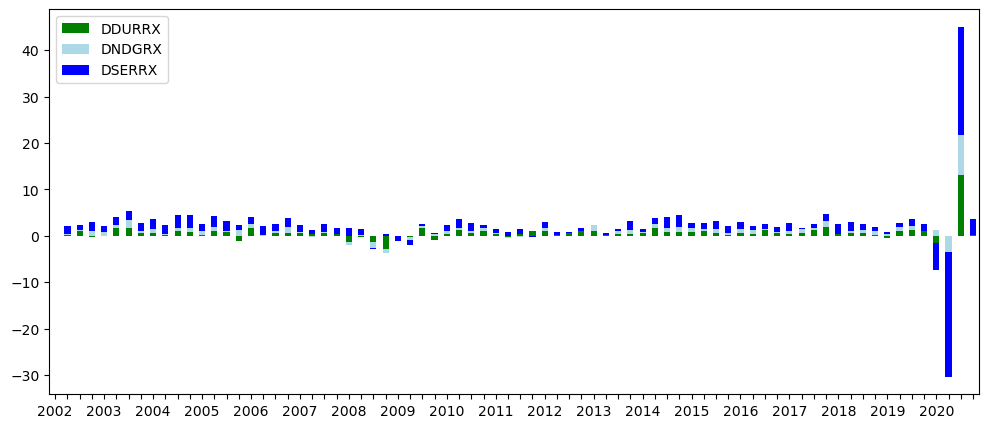

In [14]:
def line_format(index):
    label = ''
    if index.month_name()[:3] == 'Jan':
        label += f'{index.year}'
    return label

%matplotlib inline
d = df[['DDURRX', 'DNDGRX', 'DSERRX']]
ax = d.plot(kind='bar', stacked=True, figsize=(12, 5), 
            rot=0, color=['green', 'lightblue', 'blue'])
ax.set_xticklabels(map(lambda x: line_format(x), df.index));